In [89]:
# https://rhodesmill.org/skyfield/
"""
Skyfield version: 1.53
jplephem version: 2.22
sgp4 version: 2.24
Built-in leap seconds table ends with leap second at: 2016-12-31 23:59:60 UTC
Built-in ∆T table from finals2000A.all covers: 1973-01-01 to 2026-02-28
"""
import matplotlib.pyplot as plt
from skyfield.api import Loader, Topos, utc
from datetime import datetime, timedelta
import numpy as np
from datetime import datetime


In [106]:

# Setup Skyfield
load = Loader('~/skyfield-data')
ts = load.timescale()
eph = load('de421.bsp')
earth, sun, moon = eph['earth'], eph['sun'], eph['moon']

date=datetime.now().date()
print(date)

lat, lon, tz, hemi_lat, hemi_lon = 48.881953, 2.526959, 2, 'N' , 'E' #paris
#lat, lon, tz = 10.792418, 106.699402, 7 #ho chi minh
# lat, lon, tz = 13.7563, 100.5018, 6 #bangkok
# lat, lon = 1.3521, 103.8198 #singapore
# lat, lon = 35.6895, 139.6917 #tokyo
# lat, lon = 37.7749, -122.4194 #san francisco
# lat, lon = 40.7128, -74.0060 #new york
# lat, lon = 51.5074, -0.1278 #london
# lat, lon = 52.5200, 13.4050 #berlin
print(lat, lon, tz, hemi_lat, hemi_lon)

def convert(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    if minutes<=9: m = '0' 
    else : m = ''
    if sec<=9:s = '0' 
    else : s = ''
    return f'{m}{int(minutes)}:{s}{round(sec, 2)}'
    #return f'{m}{seconds//60}:{s}{round((seconds-(seconds//60)*60),2)}'

def get_data():
    observer = earth + Topos(f"{lat} {hemi_lat}", f"{lon} {hemi_lon}")
    
    # Create time range (UTC)
    start = ts.utc(date.year, date.month, date.day, -timezone_offset, range(0, 1440, 1))
    sun_apparent = observer.at(start).observe(sun).apparent()
    moon_apparent = observer.at(start).observe(moon).apparent()
    sun_alt, sun_az, _ = sun_apparent.altaz()
    moon_alt, moon_az, _ = moon_apparent.altaz()

def convert_mn(current_time):
    # Convert the time to minutes in a day
    minutes_in_day = current_time.hour * 60 + current_time.minute
    #print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")
    return minutes_in_day

def plot_sun_moon_altitude(latitude, longitude, date, timezone_offset=0, hemi_lat='N', hemi_lon='E'):
    """Plot sun altitude without almanac module."""
    observer = earth + Topos(f"{latitude} {hemi_lat}", f"{longitude} {hemi_lon}")
    
    # Create time range (UTC)
    start = ts.utc(date.year, date.month, date.day, -timezone_offset, range(0, 1440, 1))
    sun_apparent = observer.at(start).observe(sun).apparent()
    moon_apparent = observer.at(start).observe(moon).apparent()
    sun_alt, sun_az, _ = sun_apparent.altaz()
    moon_alt, moon_az, _ = moon_apparent.altaz()
    #print(alt.degrees, len(alt.degrees), max(alt.degrees))
    #print(az.degrees)#, len(alt.degrees), max(alt.degrees))
    # Convert to local hours
    hours = np.linspace(0, 24, len(sun_alt.degrees))
    # Get the current time
    current_time = datetime.now() #tz=utc)
    
    #print(np.sign(alt.degrees), np.diff(np.sign(alt.degrees)),np.where(np.diff(np.sign(alt.degrees))))
    # Find sunrise/sunset crossings manually
    noon = convert(np.argmax(sun_alt.degrees)+1)
    crossings = np.where(np.diff(np.sign(sun_alt.degrees)))[0]  # in minutes
    #print(crossings/60)
    sunrise = convert(crossings[0]-4)
    sunset = convert(crossings[1]+5)
    sunrise_az = sun_az.degrees[crossings[0]-4]
    sunset_az = sun_az.degrees[crossings[1]+5]
    #print('Sun:',sunrise, sunset)

    # Find moonrise/moonset crossings manually
    #noon = convert(np.argmax(moon_alt.degrees)+1)
    crossings2 = np.where(np.diff(np.sign(moon_alt.degrees)))[0]  # in minutes
    #print(crossings2/60, moon_alt.degrees[crossings2[0]+1], moon_alt.degrees[crossings2[1]+1])
    moonrise = convert(crossings2[0]-4)
    moonset = convert(crossings2[1]+1)
    moonrise_az = moon_az.degrees[crossings2[0]+1]
    moonset_az = moon_az.degrees[crossings2[1]+1]
    #print('Moon:',moonrise, moonset)
    
    now_mn = convert_mn(current_time) #+ timezone_offset*60
    #print(now_mn)
    print(f'Sunrise at: {sunrise} - Sunset at: {sunset} Noon: {noon}')
    print(f'Altitude: {sun_alt.degrees[now_mn]} - Azimuth: {sun_az.degrees[now_mn]}')
    # Plot
    fig, ax = plt.subplots(1, 1,figsize=(12, 6))
    plt.plot(hours, sun_alt.degrees, 'b-')
    plt.plot(hours, moon_alt.degrees, 'g-.')
    plt.plot(hours[now_mn], sun_alt.degrees[now_mn],'ro',label=f'Sun alt : {round(sun_alt.degrees[now_mn],2)}\nSun az : {round(sun_az.degrees[now_mn],2)}')
    plt.plot(hours[now_mn], moon_alt.degrees[now_mn],'go',label=f'Moon alt : {round(moon_alt.degrees[now_mn],2)}\nMoon az : {round(moon_az.degrees[now_mn],2)}')
    plt.axhline(0, color='gray', linestyle='--')
    
    # Mark crossings
    for i in crossings:
        if sun_alt.degrees[i] < 0:  # Sunrise
            plt.axvline(hours[i], color='orange', linestyle=':', label=f'Sunrise : {sunrise}' if i == crossings[0] else "")
        else:  # Sunset
            plt.axvline(hours[i], color='red', linestyle=':', label=f'Sunset : {sunset}' if i == crossings[1] else "")
    
    plt.title(f"Sun-Moon Altitude on {current_time.strftime('%Y-%m-%d at %H:%M')}")
    plt.xlabel('Local Time (hours)')
    plt.ylabel('Altitude (degrees)')
    #plt.xticks()
    ax.set_xticks(range(0,24), labels=[str(i) for i in range(0,24)])
    plt.legend()
    plt.grid()
    plt.show()

def plot_sun_moon_azimuth(latitude, longitude, date, timezone_offset=0, hemi_lat='N', hemi_lon='E'):
    """Plot sun altitude without almanac module."""
    observer = earth + Topos(f"{latitude} {hemi_lat}", f"{longitude} {hemi_lon}")
    
    # Create time range (UTC)
    start = ts.utc(date.year, date.month, date.day, -timezone_offset, range(0, 1440, 1))
    sun_apparent = observer.at(start).observe(sun).apparent()
    moon_apparent = observer.at(start).observe(moon).apparent()
    sun_alt, sun_az, _ = sun_apparent.altaz()
    moon_alt, moon_az, _ = moon_apparent.altaz()
    #print(alt.degrees, len(alt.degrees), max(alt.degrees))
    #print(az.degrees)#, len(alt.degrees), max(alt.degrees))
    # Convert to local hours
    hours = np.linspace(0, 24, len(sun_alt.degrees))
    # Get the current time
    current_time = datetime.now() #tz=utc)
    
    #print(np.sign(alt.degrees), np.diff(np.sign(alt.degrees)),np.where(np.diff(np.sign(alt.degrees))))
    # Find sunrise/sunset crossings manually
    noon = convert(np.argmax(sun_alt.degrees)+1)
    crossings = np.where(np.diff(np.sign(sun_alt.degrees)))[0]  # in minutes
    #print(crossings/60)
    sunrise = convert(crossings[0]-4)
    sunset = convert(crossings[1]+5)
    sunrise_az = sun_az.degrees[crossings[0]-4]
    sunset_az = sun_az.degrees[crossings[1]+5]
    #print('Sun:',sunrise, sunset)

    # Find moonrise/moonset crossings manually
    noon = convert(np.argmax(moon_alt.degrees)+1)
    crossings = np.where(np.diff(np.sign(moon_alt.degrees)))[0]  # in minutes
    #print(crossings/60)
    moonrise = convert(crossings[0]-4)
    moonset = convert(crossings[1]+5)
    moonrise_az = moon_az.degrees[crossings[0]-4]
    moonset_az = moon_az.degrees[crossings[1]+5]
    #print('Moon:',moonrise, moonset)

    now_mn = convert_mn(current_time) #+ timezone_offset*60
    
    print(f'Moonrise at: {moonrise} - Moonset at: {moonset} Noon: {noon}')
    print(f'Altitude: {moon_alt.degrees[now_mn]} - Azimuth: {moon_az.degrees[now_mn]}')
    # Plot
    fig, ax = plt.subplots(1, 1,figsize=(12, 6))
    plt.plot(hours, sun_az.degrees, 'b-')
    plt.plot(hours, moon_az.degrees, 'g-.')
    plt.plot(hours[now_mn], sun_az.degrees[now_mn],'ro',label=f'Sun alt : {round(sun_alt.degrees[now_mn],2)}\nSun az : {round(sun_az.degrees[now_mn],2)}')
    plt.plot(hours[now_mn], moon_az.degrees[now_mn],'go',label=f'Moon alt : {round(moon_alt.degrees[now_mn],2)}\nMoon az : {round(moon_az.degrees[now_mn],2)}')
    plt.axhline(sunrise_az, color='gray', linestyle='--')
    plt.axhline(sunset_az, color='gray', linestyle='--')
    plt.axhline(180, color='gray', linestyle='--')
    
    """
    # Mark crossings
    # for i in crossings:
    #   if if sunrise_az.degrees[i] = 0:  # Sunrise
            plt.axvline((crossings[0]-4)/60, color='orange', linestyle=':', label=f'Sunrise : {sunrise}')# if i == crossings[0] else "")
    #   else:  # Sunset
            plt.axvline((crossings[1]+5)/60, color='red', linestyle=':', label=f'Sunset : {sunset}')# if i == crossings[1] else "")
    """
    
    plt.title(f"Sun-Moon Azimuth on {current_time.strftime('%Y-%m-%d at %H:%M')}")
    plt.xlabel('Local Time (hours)')
    plt.ylabel('Altitude (degrees)')
    #plt.xticks()
    ax.set_xticks(range(0,24), labels=[str(i) for i in range(0,24)])
    plt.legend()
    #plt.grid()
    plt.show()


def scatter_position():
    """Scatter altitude, azimuth without almanac module."""
    latitude=lat
    longitude=lon
    timezone_offset = tz
    hemi_lat='N'
    hemi_lon='E'
    date=datetime.now().date()
    observer = earth + Topos(f"{latitude} {hemi_lat}", f"{longitude} {hemi_lon}")

    # Create time range (UTC)
    start = ts.utc(date.year, date.month, date.day, -timezone_offset, range(0, 1440, 1))
    sun_apparent = observer.at(start).observe(sun).apparent()
    moon_apparent = observer.at(start).observe(moon).apparent()
    sun_alt, sun_az, _ = sun_apparent.altaz()
    moon_alt, moon_az, _ = moon_apparent.altaz()

    # Get the current time
    current_time = datetime.now() #tz=utc)
    now_mn = convert_mn(current_time) + timezone_offset*60
    # Plot
    fig, ax = plt.subplots(1, 1,figsize=(12, 6))
    plt.title(f"Sun-Moon positions on {current_time.strftime('%Y-%m-%d at %H:%M')}")
    plt.ylabel('Altitude (degrees)')
    plt.xlabel('Azimuth (degrees)')
    plt.scatter(sun_az.degrees, sun_alt.degrees,s=1,color='orange')
    plt.scatter(moon_az.degrees, moon_alt.degrees,s=1,color='grey')
    plt.plot(sun_az.degrees[now_mn], sun_alt.degrees[now_mn],'ro',label=f'Sun alt : {round(sun_alt.degrees[now_mn],2)}\nSun az : {round(sun_az.degrees[now_mn],2)}')
    plt.plot(moon_az.degrees[now_mn], moon_alt.degrees[now_mn],'go',label=f'Moon alt : {round(moon_alt.degrees[now_mn],2)}\nMoon az : {round(moon_az.degrees[now_mn],2)}')
    plt.axhline(0, color='gray', linestyle='--') 
    plt.axvline(180, color='gray', linestyle='--')  
    plt.legend()

2025-05-23
48.881953 2.526959 2 N E


Sunrise at: 06:00 - Sunset at: 21:34 Noon: 13:48
Altitude: 60.52898980426335 - Azimuth: 159.39917670147415


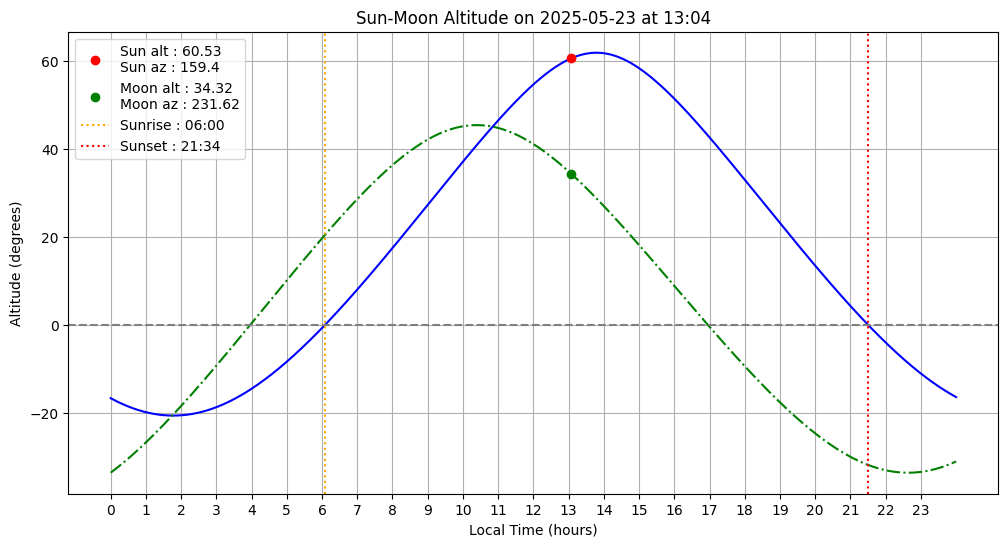

Moonrise at: 03:53 - Moonset at: 17:01 Noon: 10:24
Altitude: 34.32252031877187 - Azimuth: 231.62259503959802


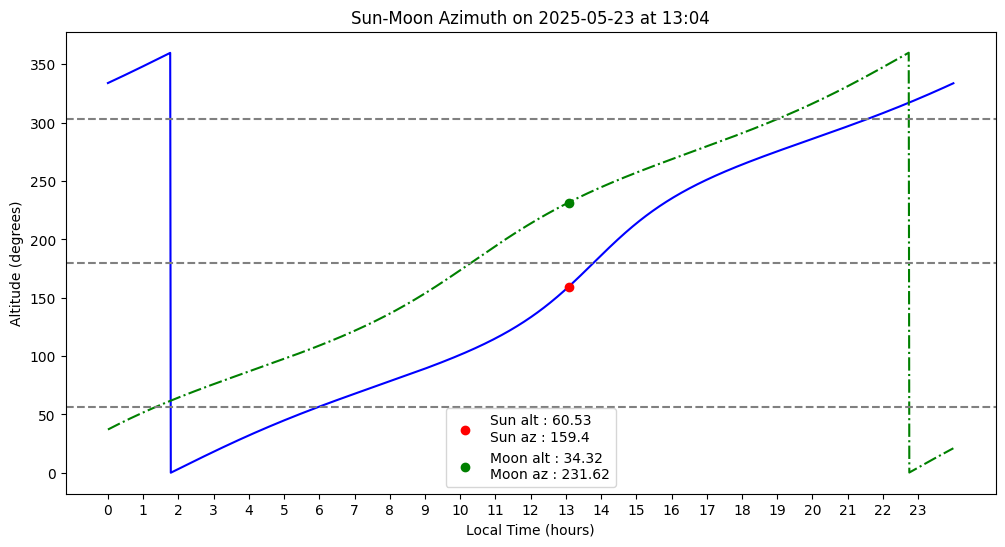

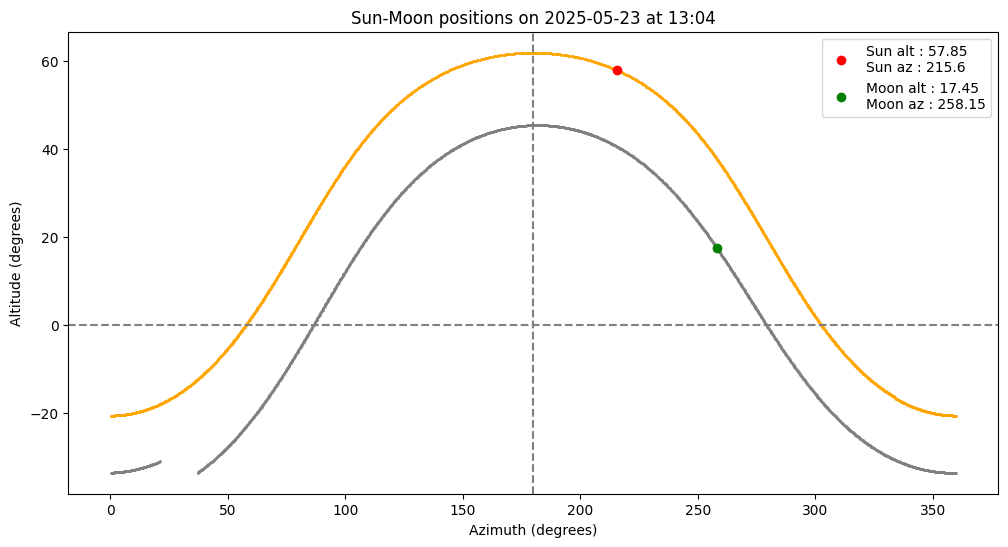

In [107]:
# Example usage
plot_sun_moon_altitude(
    latitude=lat,
    longitude=lon,
    date=date,
    timezone_offset=tz
)

# Example usage
plot_sun_moon_azimuth(
    latitude=lat,
    longitude=lon,
    date=date,
    timezone_offset=tz
)
scatter_position()